In [5]:
import pandas as pd
import numpy as np
from numpy import matlib
import time
from scipy.stats import norm
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib import rc

In [6]:
def format_axes(ax, **kwargs):
    
    """
    Format a font to my standards
    input: axes and key word arguments
    param: ax - axes to be formatted
    param: border - boolean, True = grey border, False = None. Default True
    """
    
    rc('font', family = 'serif')
    
    # Set border
    border = True
    if 'border' in kwargs:
        border = kwargs['border']
        
    if border:
        ax.spines['top'].set_color('grey')
        ax.spines['right'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        ax.spines['left'].set_color('grey')
    else:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
    # Format label and tick fonts
    tickwidth = 1
    if border == False:
        tickwidth = 2
    
    ax.xaxis.label.set_size(16)
    ax.xaxis.label.set_color('grey')
    ax.yaxis.label.set_size(16)
    ax.yaxis.label.set_color('grey')
    ax.title.set_size(16)
    ax.title.set_color('grey')
    ax.tick_params(axis='both', which='major', labelsize=16, labelcolor = 'grey')
    
    
    return ax

# Load the Data

In [7]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris['data']
y = iris['target']

df = pd.DataFrame(
    columns = ['Sepal Width', 'Sepal Length', 'Petal Length', 'Petal Width'],
    data = X
)
df['Species'] = y

# Perform kmeans

In [8]:
kmeans = KMeans(n_clusters = 3, random_state = 42).fit(X)

df['Class'] = kmeans.labels_

In [10]:
# Make sure colours are the same for the actual class and the kmeans class in the plots.
# Count the most frequent species that appears in each class
df_color_converter = df.groupby('Class', as_index = False)['Species'].mean().round().astype(int)
color_converter_dict = {}
for ind in df_color_converter.index:
    color_converter_dict[ind] = df_color_converter.loc[ind, 'Species']

# Plot the unfiltered figure

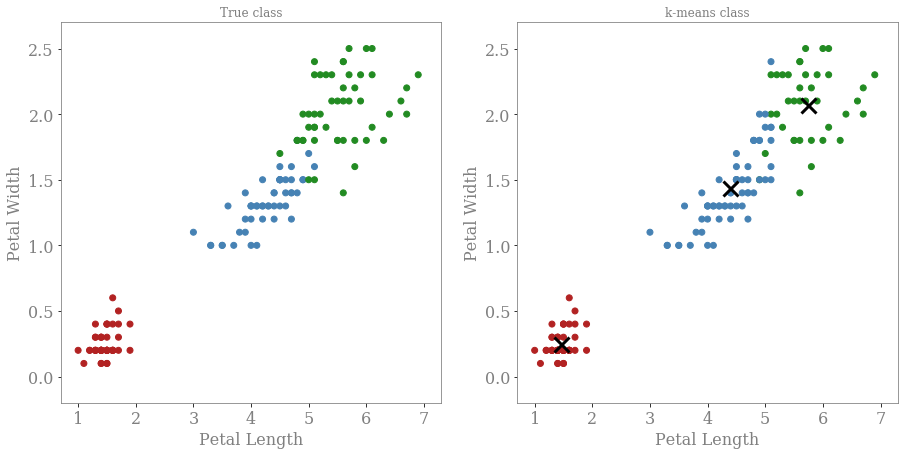

In [12]:
colors = ['firebrick', 'steelblue', 'forestgreen']

fig, axs = plt.subplots(1, 2, figsize = (15,7))

ax = format_axes(axs[0])

ax.scatter(
    X[:,2],
    X[:,3],
    color = [colors[i] for i in y]
)

ax.set_xlabel('Petal Length')
ax.set_ylabel('Petal Width')
ax.set_title('True class')

ax.set_ylim(-0.2, 2.7)
ax.set_xlim(0.7, 7.3)


ax = format_axes(axs[1])
ax.scatter(
    X[:,2],
    X[:,3],
    color = [colors[color_converter_dict[i]] for i in kmeans.labels_]
)


ax.plot(
    kmeans.cluster_centers_[:,-2],
    kmeans.cluster_centers_[:,-1],
    'xk',
    markersize = 15,
    markeredgewidth = 3
)

ax.set_xlabel('Petal Length')
ax.set_ylabel('Petal Width')
ax.set_title('k-means class')


ax.set_ylim(-0.2, 2.7)
ax.set_xlim(0.7, 7.3)

fig.savefig('Figures/kmeans.png',dpi = 500,bbox_inches='tight')

plt.show()

# Soft k-means weights

In [13]:
def soft_clustering_weights(data, cluster_centres, **kwargs):
    
    """
    Function to calculate the weights from soft k-means
    data: Array of data. Features arranged across the columns with each row being a different data point
    cluster_centres: array of cluster centres. Input kmeans.cluster_centres_ directly.
    param: m - keyword argument, fuzziness of the clustering. Default 2
    """
    
    # Fuzziness parameter m>=1. Where m=1 => hard segmentation
    m = 2
    if 'm' in kwargs:
        m = kwargs['m']
    
    Nclusters = cluster_centres.shape[0]
    Ndp = data.shape[0]
    Nfeatures = data.shape[1]

    # Get distances from the cluster centres for each data point and each cluster
    EuclidDist = np.zeros((Ndp, Nclusters))
    for i in range(Nclusters):
        EuclidDist[:,i] = np.sum((data-np.matlib.repmat(cluster_centres[i], Ndp, 1))**2,axis=1)
    

    
    # Denominator of the weight from wikipedia:
    invWeight = EuclidDist**(2/(m-1))*np.matlib.repmat(np.sum((1./EuclidDist)**(2/(m-1)),axis=1).reshape(-1,1),1,Nclusters)
    Weight = 1./invWeight
    
    return Weight

# Plot the filtered k-mean figure

In [17]:
for i in range(3):
    df['p' + str(i)] = 0
    
df[['p0', 'p1', 'p2']] = soft_clustering_weights(X, kmeans.cluster_centers_)

In [18]:
df['confidence'] = np.max(df[['p0', 'p1', 'p2']].values, axis = 1)

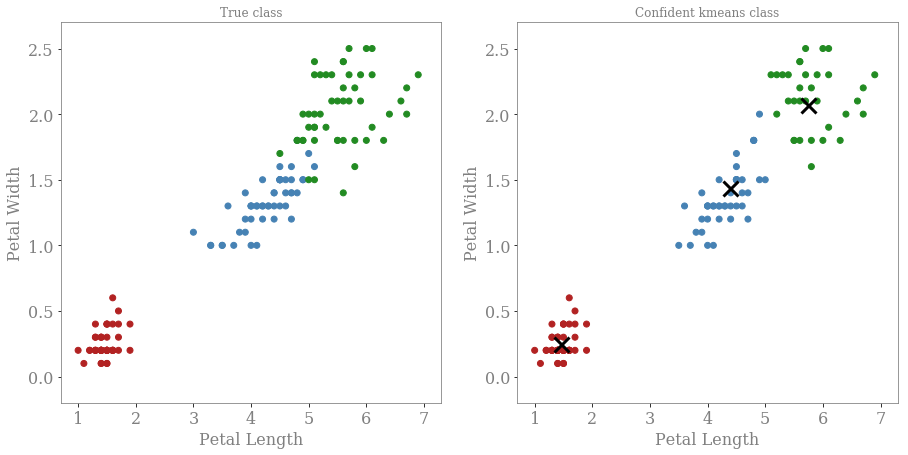

In [19]:
colors = ['firebrick', 'steelblue', 'forestgreen']

fig, axs = plt.subplots(1, 2, figsize = (15,7))

ax = format_axes(axs[0])

ax.scatter(
    X[:,2],
    X[:,3],
    color = [colors[i] for i in y]
)

ax.set_xlabel('Petal Length')
ax.set_ylabel('Petal Width')
ax.set_title('True class')

ax.set_ylim(-0.2, 2.7)
ax.set_xlim(0.7, 7.3)


ax = format_axes(axs[1])

ax.scatter(
    df.loc[df['confidence'] > 0.9, 'Petal Length'],
    df.loc[df['confidence'] > 0.9, 'Petal Width'],
    color = df.loc[df['confidence'] > 0.9, 'Class'].apply(lambda x: colors[color_converter_dict[x]])
)

ax.plot(
    kmeans.cluster_centers_[:,-2],
    kmeans.cluster_centers_[:,-1],
    'xk',
    markersize = 15,
    markeredgewidth = 3
)

ax.set_xlabel('Petal Length')
ax.set_ylabel('Petal Width')
ax.set_title('Confident kmeans class')

fig.savefig('Figures/confident_kmeans.png', dpi = 500, bbox_inches = 'tight')


ax.set_ylim(-0.2, 2.7)
ax.set_xlim(0.7, 7.3)

plt.show()